In [771]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv


In [3]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()



In [6]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


# From Guided Example

In [7]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)



In [791]:
def guidedExPercentErrTypes (X,y,**params):
    
    # Create training and test sets.
    offset = int(X.shape[0] * 0.9)

    # Put 90% of the data in the training set.
    X_train, y_train = X[:offset], y[:offset]

    # And put 10% in the test set.
    X_test, y_test = X[offset:], y[offset:]
    
    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


In [793]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

guidedExPercentErrTypes (X,y,**params)

Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


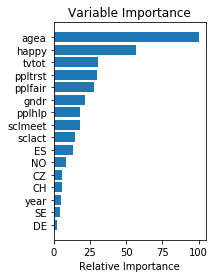

In [5]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Baseline

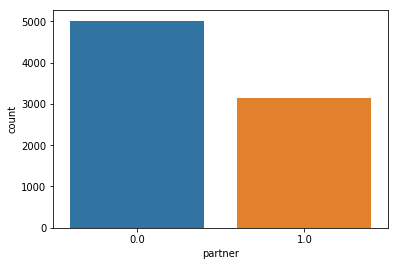

In [773]:
g = sns.countplot(x=y, data=X)
plt.show()

In [786]:
from collections import Counter
counts = Counter(y)
print ("BASELINE: {}".format(counts[1.0]/counts[0.0]))

BASELINE: 0.6251745461799322


# Class: Gradient Boost Tuner

In [796]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
import time
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import cross_val_score 
from IPython.display import clear_output

class Tuner():
    
    def __init__(self,X,y,cvFolds=10, **tunerRanges):
        self.X = X
        self.y = y
        self.cvFolds = cvFolds
        self.results = pd.DataFrame()
        self.results = pd.DataFrame(columns=['Name', 'Accuracy', 'Range', 'CrossValScores'])
        self.setTunerSpecific(**tunerRanges)
        self.genResults()
    
    def DisplayResultsGraph(self):
        labels = []
        widthscale = self.results.shape[0]/4
        if widthscale < 8:
            widthscale = 8
        plt.figure(figsize=(widthscale,6))
        plt.plot(self.results['Accuracy'])
        labels.append('Accuracy')
        plt.plot(self.results['Accuracy'] + self.results['Range'])
        labels.append('Accuracy + Range')
        plt.legend(labels)
        plt.xticks(np.arange(self.results.shape[0]), (self.results['Name']),rotation=90)
        plt.show()
    
    def DisplayResultsSummary(self):
        resultSortAcc = self.results.sort_values('Accuracy', ascending=False)
        resultSortRan = self.results.sort_values('Range', ascending=True)
        
        print("Highest Accuracy")
        display(resultSortAcc.head())
        
        print("\nLowest Range")
        display(resultSortRan.head())
        
    def FullResult(self):
        self.DisplayResultsGraph()
        self.DisplayResultsSummary()
        
    def disBox(self):
        plt.boxplot(self.results)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()
                    
class GradientBoostTuner(Tuner):
    
    def setTunerSpecific(self,**tunerRanges):
        paramList = itertools.product(
            ranges['loss'], 
            ranges['n_esitmators'], 
            ranges['max_depth'],
            ranges['max_leaf_nodes'])
        self.__setParamsResultList(paramList)
        
    def __setParamsResultList(self,paramList):
        for i in paramList:
            name = "{0} d:{1} e:{2}".format(i[0][:1],i[1],i[2])
            self.results = self.results.append({'Name':name, 
                            'loss':i[0],
                           'n_estimators':i[1],
                           'max_depth':i[2],
                            'max_leaf_nodes':i[3]}, ignore_index=True)
    
    def genResults(self): 
        totIter = self.results.shape[0]
        c=1
        for index,row in self.results.iterrows():
            params = {'n_estimators': int(row.n_estimators),
                     'max_depth': int(row.max_depth),
                      'max_leaf_nodes':int(row.max_leaf_nodes),
                     'loss': row.loss}
            gb = ensemble.GradientBoostingClassifier(**params)
            cvs = cross_val_score(gb,self.X,self.y,cv=self.cvFolds)
            self.results.set_value(index,'CrossValScores', cvs)
            self.results.set_value(index,'Accuracy', np.mean(cvs))
            self.results.set_value(index,'Range', max(cvs)-min(cvs))
            clear_output()
            print ("{:.0%} {}".format((c/totIter), self.results.iloc[index].Name))
            c += 1
        self.results = self.results.sort_values(['Accuracy'], axis=0)
        self.results = self.results.reset_index(drop=True)

# Iterations to Improve Model

In [799]:
ranges = {'loss': ['exponential', 'deviance'],
    'n_esitmators': range(20,50,1),
    'max_depth': range(1,5,1),
    'max_leaf_nodes': range(1,5,1)}
gradBoostTuner6 = GradientBoostTuner(X,y,cvFolds=5,**ranges)
gradBoostTuner6.FullResult()

ValueError: max_leaf_nodes 1 must be either None or larger than 1

ValueError: max_leaf_nodes 1 must be either None or larger than 1

100% d d:580 e:9


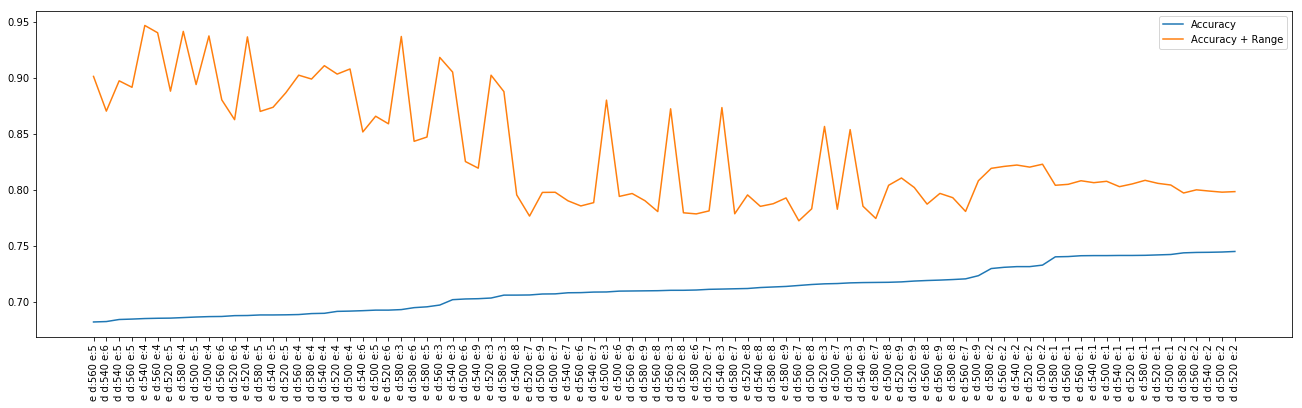

Highest Accuracy


,Name,Accuracy,Range,CrossValScores,loss,max_depth,n_estimators
89,d d:520 e:2,0.745302,0.0533742,"[0.769325153374, 0.715950920245, 0.76441717791...",deviance,2.0,520.0
88,d d:500 e:2,0.744811,0.0533742,"[0.769325153374, 0.715950920245, 0.76380368098...",deviance,2.0,500.0
87,d d:540 e:2,0.744565,0.0546012,"[0.769325153374, 0.71472392638, 0.765644171779...",deviance,2.0,540.0
86,d d:560 e:2,0.744443,0.0558282,"[0.769938650307, 0.714110429448, 0.76319018404...",deviance,2.0,560.0
85,d d:580 e:2,0.744075,0.0533742,"[0.768098159509, 0.71472392638, 0.762576687117...",deviance,2.0,580.0



Lowest Range


,Name,Accuracy,Range,CrossValScores,loss,max_depth,n_estimators
89,d d:520 e:2,0.745302,0.0533742,"[0.769325153374, 0.715950920245, 0.76441717791...",deviance,2.0,520.0
85,d d:580 e:2,0.744075,0.0533742,"[0.768098159509, 0.71472392638, 0.762576687117...",deviance,2.0,580.0
88,d d:500 e:2,0.744811,0.0533742,"[0.769325153374, 0.715950920245, 0.76380368098...",deviance,2.0,500.0
87,d d:540 e:2,0.744565,0.0546012,"[0.769325153374, 0.71472392638, 0.765644171779...",deviance,2.0,540.0
86,d d:560 e:2,0.744443,0.0558282,"[0.769938650307, 0.714110429448, 0.76319018404...",deviance,2.0,560.0


In [789]:
ranges = {'loss': ['exponential', 'deviance'],
    'n_esitmators': range(500,600,20),
    'max_depth': range(1,10,1)}
gradBoostTuner7 = GradientBoostTuner(X,y,cvFolds=5,**ranges)
gradBoostTuner7.FullResult()

# Redo Guided Example with New Parameters

### Best Tuing Parameters

In [794]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

guidedExPercentErrTypes (X,y,**params)

Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


In [800]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
             'max_leaf_nodes': 5}

guidedExPercentErrTypes (X,y,**params)

Training set accuracy:
Percent Type I errors: 0.040098199672667756
Percent Type II errors: 0.16284779050736498

Test set accuracy:
Percent Type I errors: 0.06748466257668712
Percent Type II errors: 0.17668711656441718


### Guided Example Parameters

In [795]:
params = {'n_estimators': 39,
          'max_depth': 3,
          'loss': 'deviance'}

guidedExPercentErrTypes (X,y,**params)

Training set accuracy:
Percent Type I errors: 0.036552100381887616
Percent Type II errors: 0.20076377523186034

Test set accuracy:
Percent Type I errors: 0.04539877300613497
Percent Type II errors: 0.2147239263803681


# Conclusion

Exploring various values for loss function vs the number of iterations vs the depth of the 